In [1]:
lib = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/'
import sys
sys.path.append(lib)
from utilities.package_importing import *
import scipy.stats as stats
import warnings 
warnings.filterwarnings("ignore")

#### Build cohort

In [2]:
data_path = r'/storage/md_keren/shitay/Data/smart_seq/SmartSeq_RNAseq_DATA.p'
cells, gene_names, patients_information = extract_smart_seq_data_from_pickle(data_path)

from utilities.smart_seq_dataset import RNAseq_Dataset
cohort = RNAseq_Dataset(cells, patients_information, gene_names)

In [3]:
from anndata import AnnData
annCohort = AnnData(cohort.cells)

In [4]:
annCohort.var['gene'] = cohort.gene_names

annCohort.obs['sample'] = [cell.patient_details for cell in cohort.cells_information_list] 
annCohort.obs['barcode'] = [cell.cell_id for cell in cohort.cells_information_list] 
annCohort.obs['cell_type'] = [cell.supervised for cell in cohort.cells_information_list] 
annCohort.obs['response'] = [cell.response for cell in cohort.cells_information_list] 
annCohort.obs['pre/post'] = [p.split('_')[0] for p in annCohort.obs['sample'].values.tolist()]

#### Take only activated T cells

In [5]:
# annCohort.obs.cell_type
cell_type = 'Activated T cells'
cell_type_indices = [cell_type in cell_types for cell_types in annCohort.obs['cell_type']]
cell_type_indices = cell_type_indices #& (annCohort.obs['pre/post'] == 'Post')

activated_t_cells_cohort = annCohort[cell_type_indices, :]

### Extract top 20 genes

In [6]:
### The genes with the highest feature score found in the course CB (DAVID work!)
# TOP_GENES_FILE = r'/storage/md_keren/shitay/outputs/thesis/XGBoost/smartseq/feature_importance_top_20.xlsx'
# top_genes = pd.read_excel(TOP_GENES_FILE)[['Gene', 'Total feature importance score']].sort_values('Total feature importance score', ascending=False).reset_index(drop=True)

### The genes that were found in the new XGBoosts trained on activated T cells with fixed number of 4k genes (13.6.22), not used in the course CB.
top_genes = pd.DataFrame(np.array([['GAPDH', 'PSME2', 'GZMH', 'STAT1', 'ANXA2', 'MS4A1', 'TGFBI', 'CCR7', 'CD79A', 'IFI6', 'CD38', 'IFI44L', 'ANXA5', 'TYROBP', 'WARS', 'GBP5', 'EPSTI1', 'GZMB', 'S100A4', 'LGALS1'],
                          list(range(20))]).T,
                            columns=['Gene', 'feature_score'])

#### Plot distribution to gene expression:

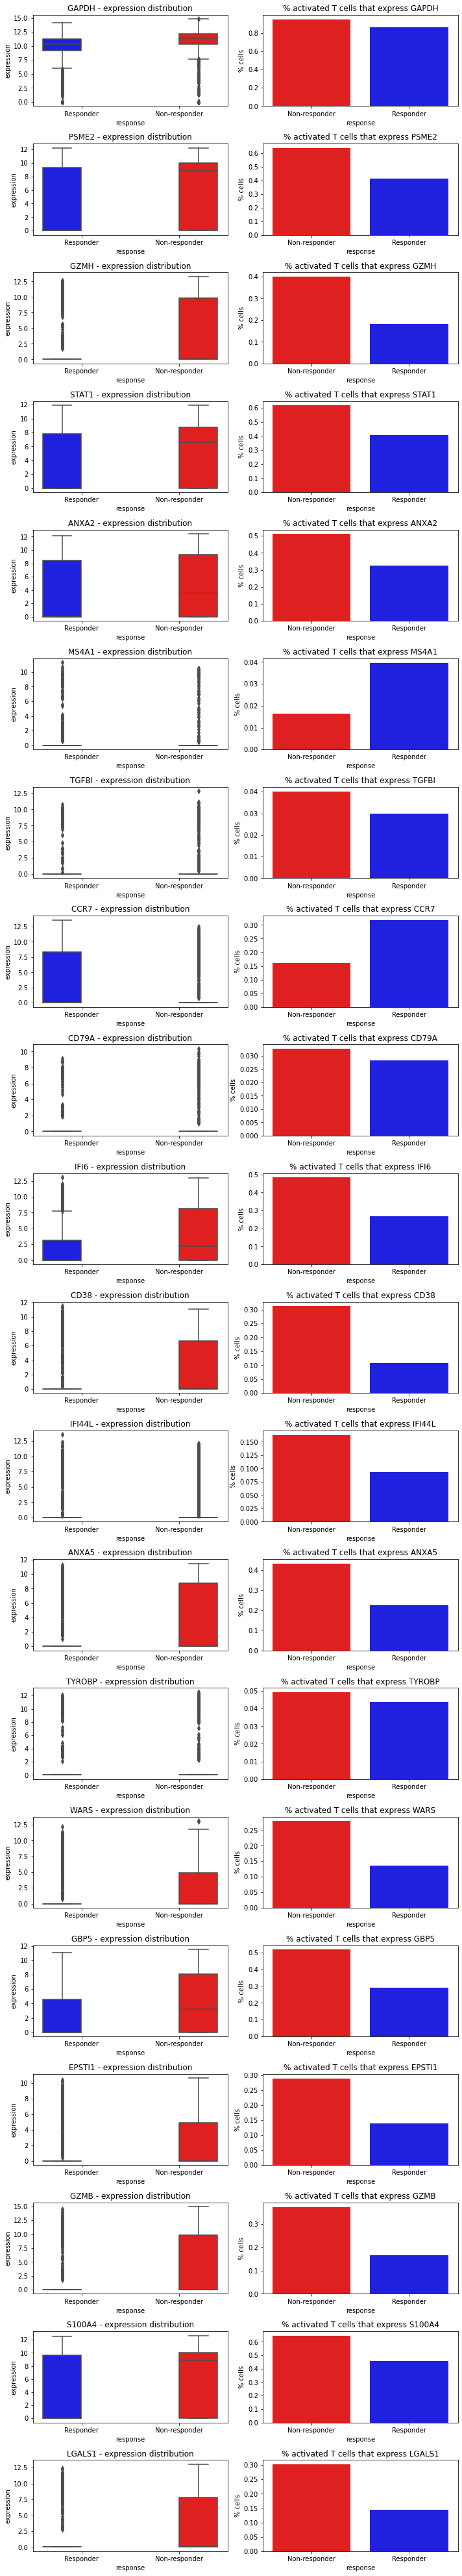

In [8]:
top_k = 20
plt.rcdefaults()  # reset params
sns.reset_orig() # reset size of figure

fig, axs = plt.subplots(top_k, 2)
fig.set_size_inches(10, 3*top_k)


for idx, (gene, feature_importance_score) in top_genes.iloc[:top_k].iterrows():
    
    gene = top_genes.iloc[idx].Gene


    #####################

    gene_expressed_threshold = 2.5

    gene_cohort = activated_t_cells_cohort[:,  activated_t_cells_cohort.var['gene']==gene]

    R_cohort = gene_cohort[gene_cohort.obs.response == 'Responder', :]
    NR_cohort = gene_cohort[gene_cohort.obs.response == 'Non-responder', :]

    expression_df = pd.DataFrame([gene_cohort.X[:,-1], gene_cohort.obs.response], index=['expression', 'response']).T

    g = sns.boxplot(x='response', y='expression', hue='response',
                data=expression_df, palette={"Responder": "b", "Non-responder": "r"}, ax=axs[idx][0]).set(title=f'{gene} - expression distribution');
    axs[idx][0].legend([],[], frameon=False)


    per_df = (expression_df[expression_df.expression > gene_expressed_threshold].groupby('response').count() / expression_df.groupby('response').count()).reset_index().rename(columns={'expression': '% cells'})
    sns.barplot(x='response', y='% cells', data=per_df, palette={"Responder": "b", "Non-responder": "r"}, ax=axs[idx][1]).set(title=f'% activated T cells that express {gene}');
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# fig.savefig(r'/storage/md_keren/shitay/outputs/thesis_visualizations/XGBoost/smartseq/dist.jpg')

### Plot tSNE of gens:

In [7]:
import scanpy as sc
my_df = pd.DataFrame(activated_t_cells_cohort.X, columns=activated_t_cells_cohort.var.gene.tolist())
data = AnnData(my_df)

sc.tl.pca(data)
sc.pp.neighbors(data)
sc.tl.tsne(data)

In [8]:
data.obs['response'] = activated_t_cells_cohort.obs.response.tolist()

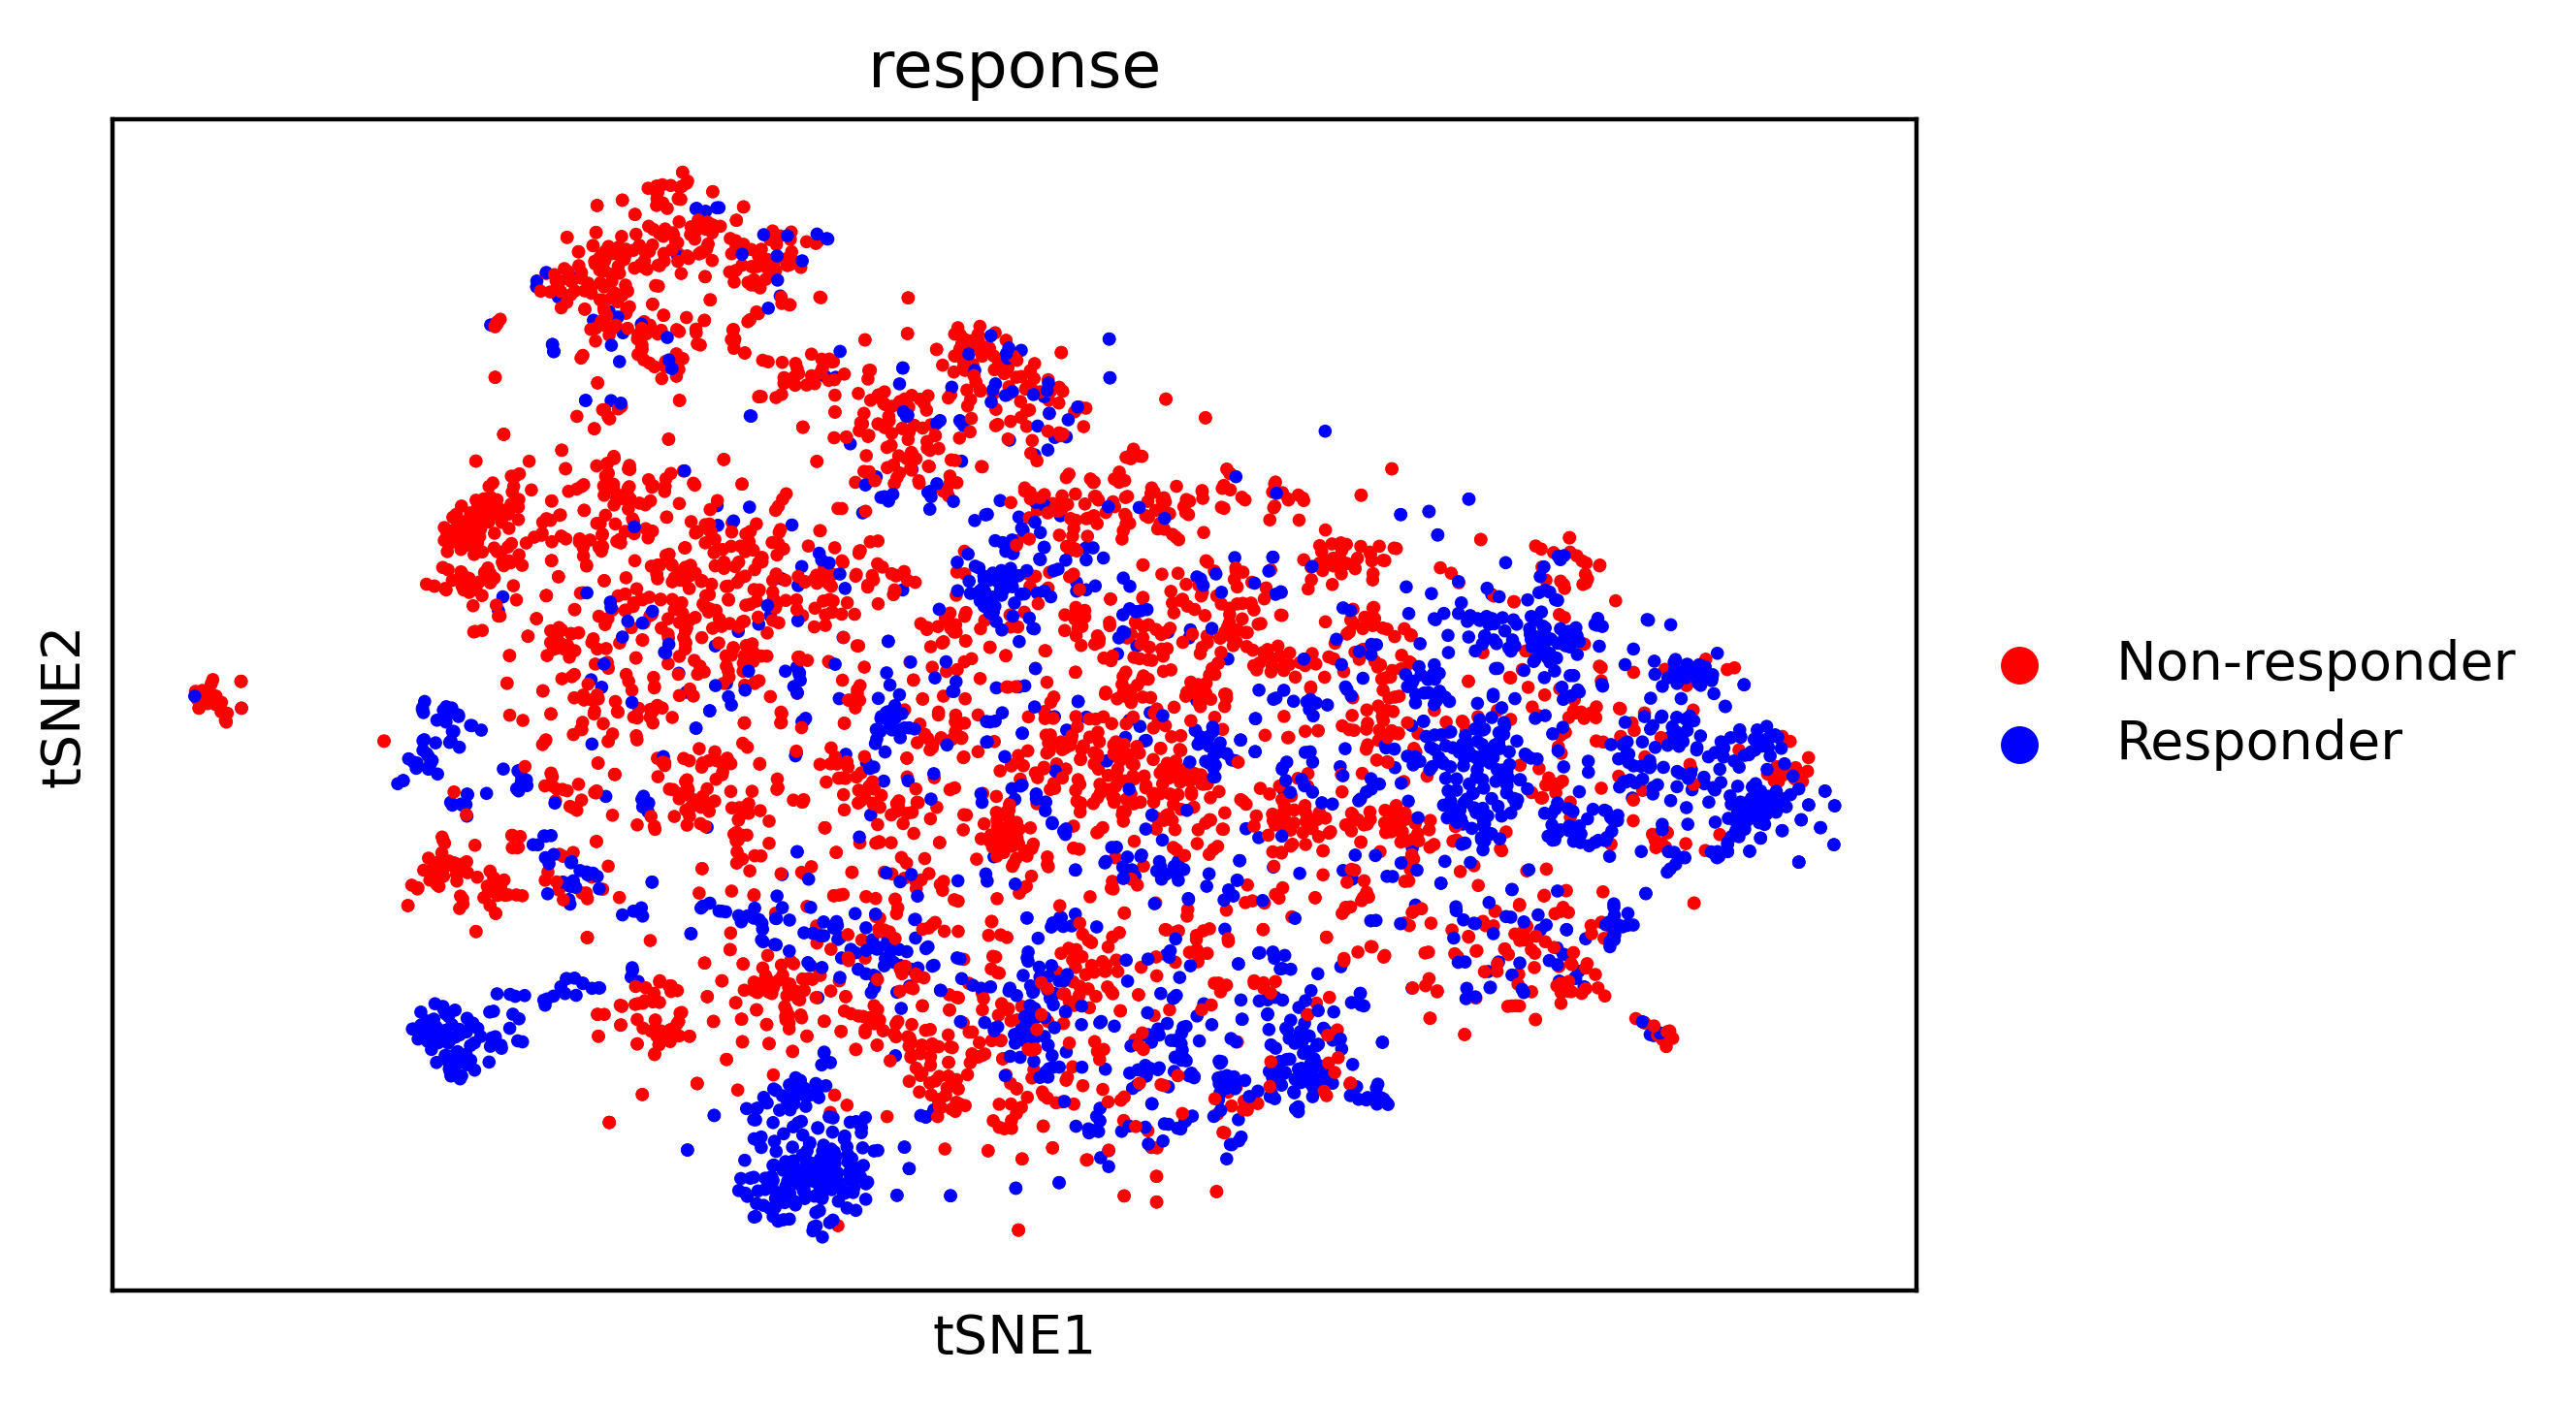

In [17]:
sc.pl.tsne(data, color =['response'], save='_response_tsne.png', palette = {'Responder': 'b', 'Non-responder':'r'})

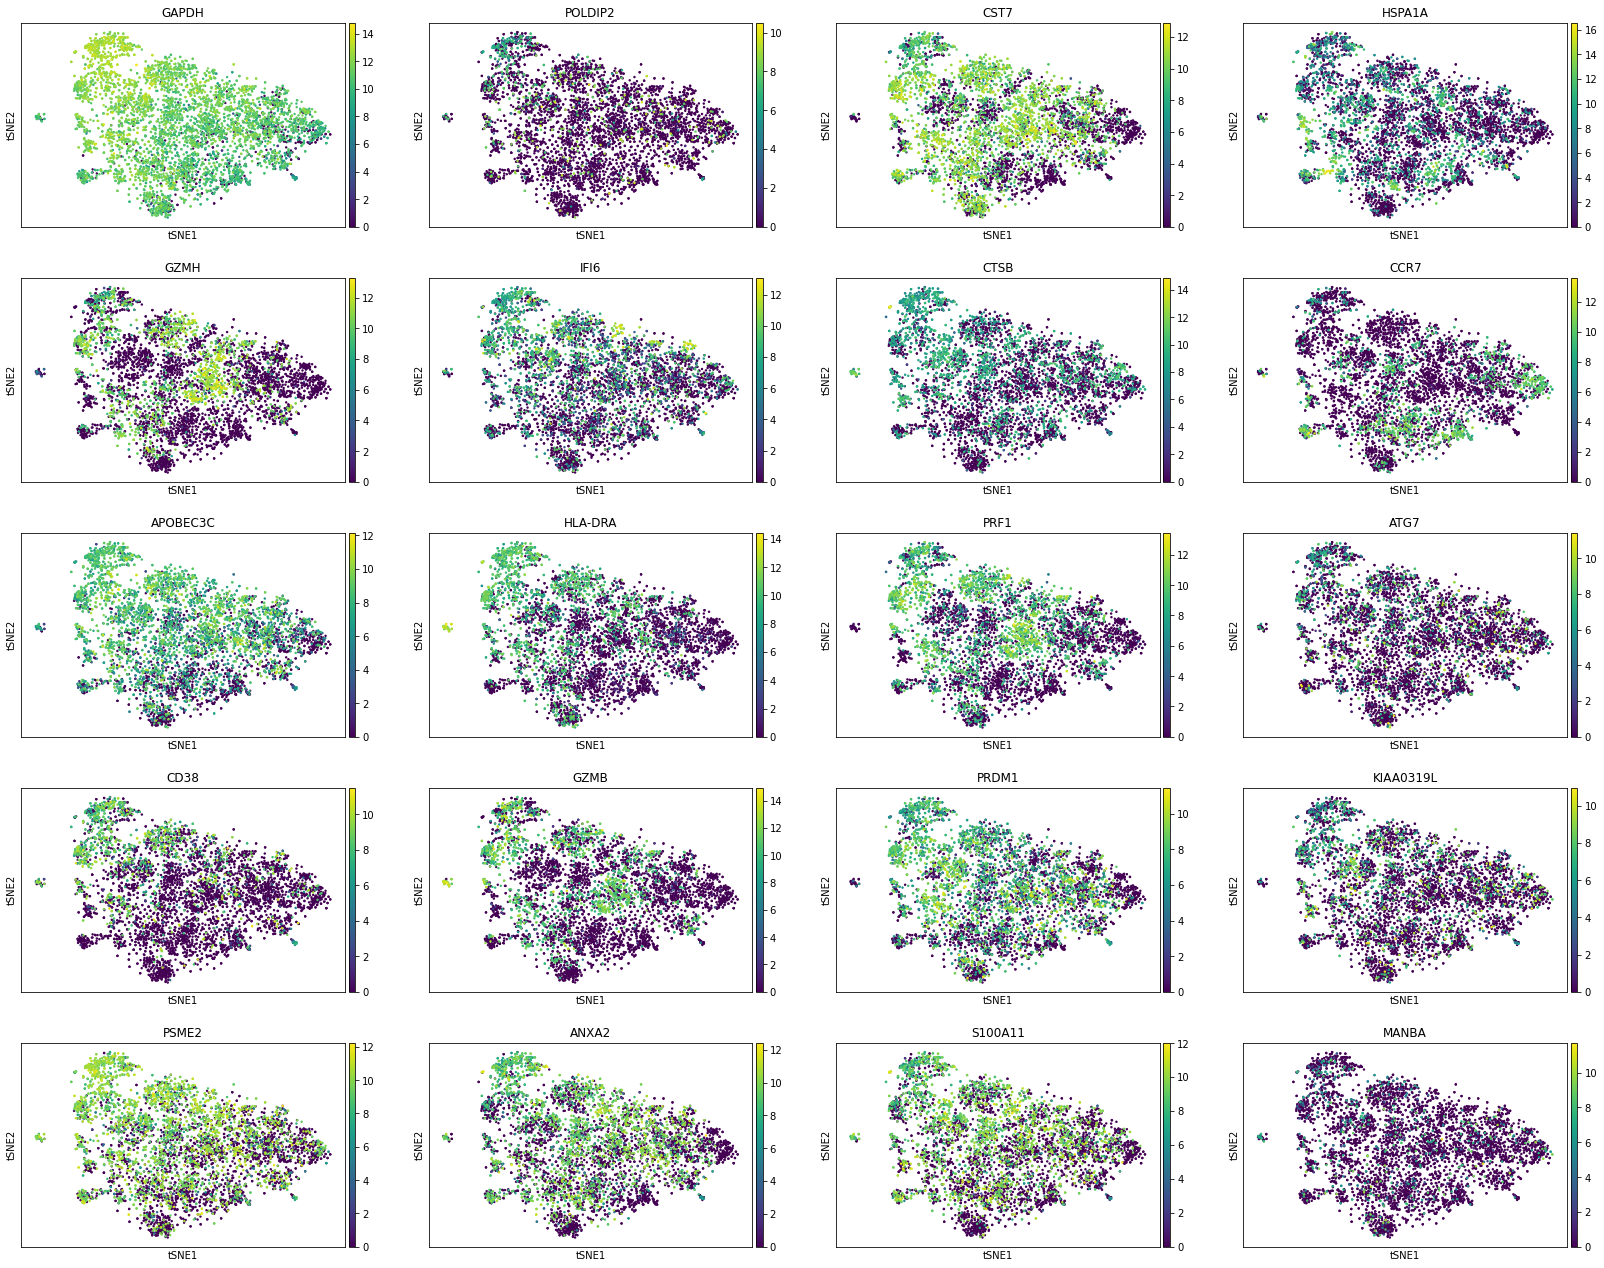

In [357]:
top_k = 20


l = top_genes.iloc[:20].Gene.tolist()
l2 = flatten_list(np.array([[g for i, g in enumerate(l) if i%5==r] for r in range(5)]).tolist())
fig = sc.pl.tsne(data, color=l2, save='top_20_genes.png')


# Conduct DEA between R and NR (qval calculation):

In [41]:
gene_expressed_threshold = 2.5

pval_df = pd.DataFrame(columns=['gene', 'pval'])

for idx, (gene, feature_importance_score) in top_genes.iloc[:top_k].iterrows():


    gene_expressed_threshold = 2.5

    gene_cohort = activated_t_cells_cohort[:,  activated_t_cells_cohort.var['gene']==gene]

    R_cohort = gene_cohort[gene_cohort.obs.response == 'Responder', :]
    NR_cohort = gene_cohort[gene_cohort.obs.response == 'Non-responder', :]
    expression_df = pd.DataFrame([gene_cohort.X[:,-1], gene_cohort.obs.response], index=['expression', 'response']).T

    R_exp = expression_df[expression_df.response=='Responder'].expression.values
    NR_exp = expression_df[expression_df.response!='Responder'].expression.values

    number_of_cells_expressing_gene_in_cluster = sum(R_exp > gene_expressed_threshold)
    number_of_cells_expressing_gene_in_other_clusters = sum(NR_exp > gene_expressed_threshold)
    n_cells_in_cluster = len(R_exp)
    n_cells_in_other_clusters = len(NR_exp)
    oddsratio, pvalue = stats.fisher_exact([[number_of_cells_expressing_gene_in_cluster,
                                                 number_of_cells_expressing_gene_in_other_clusters],
                                                [n_cells_in_cluster - number_of_cells_expressing_gene_in_cluster,
                                                 n_cells_in_other_clusters - number_of_cells_expressing_gene_in_other_clusters]])
    
    pval_df = pval_df.append(pd.DataFrame([[gene, pvalue]], columns=pval_df.columns))
pval_df['qval'] = multipletests_fdr(pval_df.pval)[1].values
pval_df['sig'] = pval_df['qval'] < 0.05
pval_df

,gene,pval,qval,sig
0,GAPDH,3.771277e-27,5.028369e-27,True
0,PSME2,9.461663e-56,3.784665e-55,True
0,GZMH,4.794600e-61,4.794600e-60,True
0,STAT1,1.341920e-49,3.354801e-49,True
0,ANXA2,9.528847e-38,1.732518e-37,True
0,MS4A1,6.787068e-07,7.984786e-07,True
0,TGFBI,6.217851e-02,6.908723e-02,False
0,CCR7,2.472412e-37,4.120686e-37,True
0,CD79A,4.038663e-01,4.251224e-01,False
0,IFI6,1.311733e-52,4.372444e-52,True


# Save 4k highest variance genes:

In [8]:
cohort.cells.shape
required_variance = 6
big_variance_genes = np.var(cohort.cells, axis=0) > required_variance


In [14]:
# sum(big_variance_genes)
# big_variance_genes
cohort.filter_genes_by_variance(6)

Dataset was cleared from genes with variance of less than 6


In [17]:
cohort.cells.shape

(16291, 4141)

# DEBUG

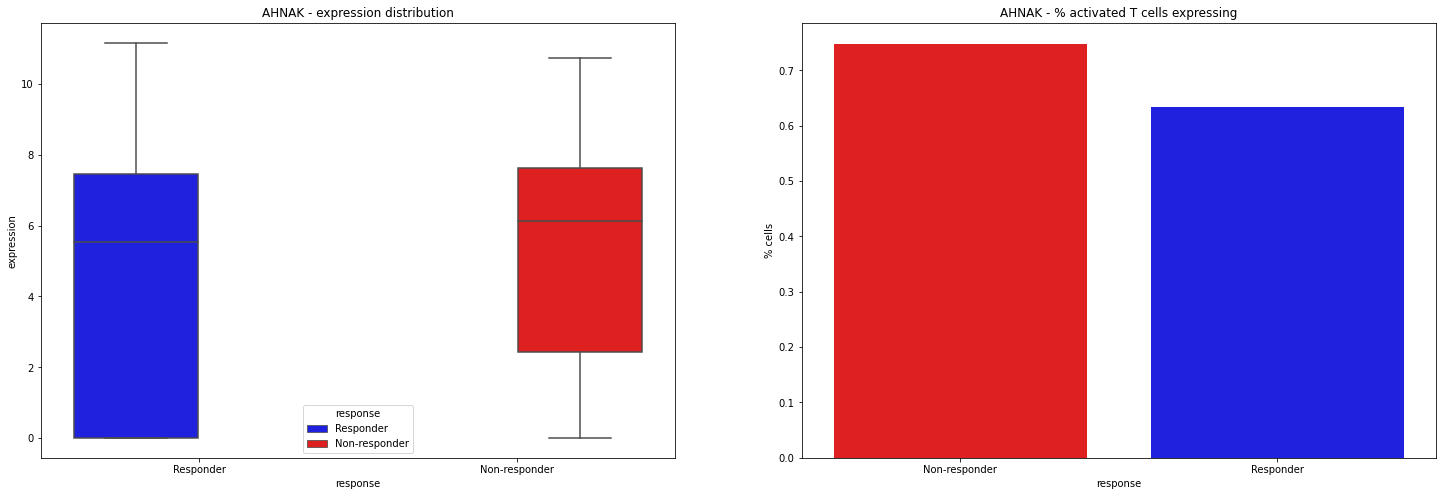

In [158]:
idx = 4
gene = top_genes.iloc[idx].Gene


#####################
fig, axs = plt.subplots(1,2)
fig.set_size_inches(25, 4*2)


gene_expressed_threshold = 2.5

gene_cohort = activated_t_cells_cohort[:,  activated_t_cells_cohort.var['gene']==gene]

R_cohort = gene_cohort[gene_cohort.obs.response == 'Responder', :]
NR_cohort = gene_cohort[gene_cohort.obs.response == 'Non-responder', :]

expression_df = pd.DataFrame([gene_cohort.X[:,-1], gene_cohort.obs.response], index=['expression', 'response']).T
# binary_df = pd.DataFrame([gene_cohort.X[:,-1] > gene_expressed_threshold, gene_cohort.obs.response], index=['expression', 'response']).T
# binary_df = expression_df[expression_df.expression > gene_expressed_threshold]

sns.reset_orig() # reset size of figure
sns.boxplot(x='response', y='expression', hue='response',
            data=expression_df, palette={"Responder": "b", "Non-responder": "r"}, ax=axs[0]).set(title=f'{gene} - expression distribution');

per_df = (expression_df[expression_df.expression > gene_expressed_threshold].groupby('response').count() / expression_df.groupby('response').count()).reset_index().rename(columns={'expression': '% cells'})
sns.barplot(x='response', y='% cells', data=per_df, palette={"Responder": "b", "Non-responder": "r"}, ax=axs[1]).set(title=f'{gene} - % activated T cells expressing');

<AxesSubplot:xlabel='response', ylabel='count'>

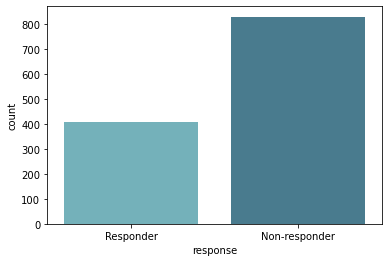

In [115]:
binary_df
sns.countplot(x='response', data=binary_df,palette='GnBu_d')#.set(title=ligand);


In [5]:
from MachineLearning.smartseq_env.Models.enhanced_xgboost import Enhanced_XGboost

In [3]:
path = r'/storage/md_keren/shitay/outputs/CB_final_projects/Experiments_10.1.21/exp_78/Enhanced_XGboost_Model.pkl'
model = pickle.load(open(path, 'rb'))


In [8]:
# plot decision tree
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_tree
import matplotlib.pyplot as plt
# plot_tree(model)


In [13]:
# R_cohort.X.mean()
# NR_cohort.X.mean()

d = np.array(NR_cohort.X)
np.median(d)

11.34

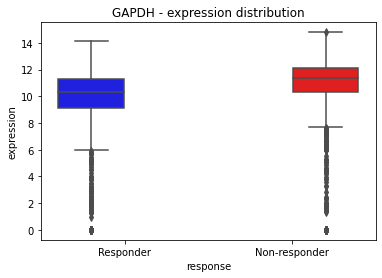

In [7]:
sns.reset_orig() # reset size of figure

gene = 'GAPDH'


#####################

gene_expressed_threshold = 2.5

gene_cohort = activated_t_cells_cohort[:,  activated_t_cells_cohort.var['gene']==gene]

R_cohort = gene_cohort[gene_cohort.obs.response == 'Responder', :]
NR_cohort = gene_cohort[gene_cohort.obs.response == 'Non-responder', :]

expression_df = pd.DataFrame([gene_cohort.X[:,-1], gene_cohort.obs.response], index=['expression', 'response']).T

g = sns.boxplot(x='response', y='expression', hue='response',
            data=expression_df, palette={"Responder": "b", "Non-responder": "r"}).set(title=f'{gene} - expression distribution');
plt.legend([],[], frameon=False)


